# October 30th, 2021

**Motivation**: Hierarchical group results, BOLD: no GSR <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
from nancorrmp.nancorrmp import NaNCorrMp
from analysis.hierarchical import get_clust_graph, sp_hier

def fit_hier_group(mode, task, nogsr):
    mice = Mice((512, 4))
    mice.setup_func_data(task, nogsr=nogsr)
    proc, *_ = mice.get_data_containers(mode)

    adj_pears = []
    adj_spear = []
    for key, func in tqdm(proc.items()):
        if mice.looper[key][-1] < 0:
            continue

        base = Base(mice, key=key, mode=mode, task=task)

        a, p = NaNCorrMp.calculate_with_p_value(base.data)
        a[p > 0.05] = np.nan
        adj_pears.append(np.expand_dims(a, 0))

        a, p = sp_stats.spearmanr(base.data, axis=1)
        a[p > 0.05] = np.nan
        adj_spear.append(np.expand_dims(a, 0))

    adj_pears = np.concatenate(adj_pears)
    adj_pears = bn.nanmean(adj_pears, 0)
    adj_spear = np.concatenate(adj_spear)
    adj_spear = bn.nanmean(adj_spear, 0)

    for i in range(len(adj_pears)):
        nans = np.isnan(adj_pears[i])
        adj_pears[i][nans] = bn.nanmean(adj_pears[i])

    for i in range(len(adj_spear)):
        nans = np.isnan(adj_spear[i])
        adj_spear[i][nans] = bn.nanmean(adj_spear[i])

    a_sym = (adj_pears + adj_pears.T) / 2
    d_pears = 1 - a_sym

    a_sym = (adj_spear + adj_spear.T) / 2
    d_spear = 1 - a_sym
    
    z_pears = sp_hier.linkage(
        sp_dist.squareform(d_pears),
        method='ward',
        metric='correlation',
        optimal_ordering=True,
    )
    result = get_clust_graph(
        linkage_mat=z_pears,
        labels=base.l2n,
        num_clusters=5,
    )
    comm_vec = np.zeros(len(base.n2l))
    for c_idx, clist in result['cluster_assigns'].items():
        for lbl in clist:
            comm_vec[base.l2n[lbl]] = c_idx
    proj_pears = base.project_vec(comm_vec)

    z_spear = sp_hier.linkage(
        sp_dist.squareform(d_spear),
        method='ward',
        metric='correlation',
        optimal_ordering=True,
    )
    result = get_clust_graph(
        linkage_mat=z_spear,
        labels=base.l2n,
        num_clusters=5,
    )
    comm_vec = np.zeros(len(base.n2l))
    for c_idx, clist in result['cluster_assigns'].items():
        for lbl in clist:
            comm_vec[base.l2n[lbl]] = c_idx
    proj_spear = base.project_vec(comm_vec)
    
    output = {
        'd_pears': d_pears,
        'd_spear': d_spear,
        'proj_pears': proj_pears,
        'proj_spear': proj_spear,
    }
    return output

In [3]:
ca2_led = fit_hier_group('ca2', 'led', True)
ca2_rest = fit_hier_group('ca2', 'rest', True)

bold_led = fit_hier_group('bold-lite', 'led', True)
bold_rest = fit_hier_group('bold-lite', 'rest', True)

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

In [7]:
mice = Mice((512, 4))
base = Base(mice)

In [8]:
figs, sups = [], []

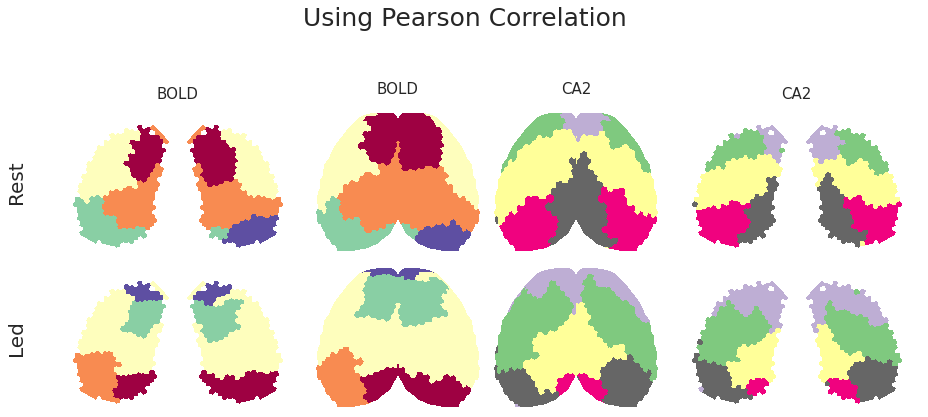

In [9]:
cmaps = ('Spectral_r', 'Accent_r')

fig, axes = create_figure(2, 4, (13, 5.5), gridspec_kw={'width_ratios': [1.5, 1, 1, 1.5]})

tr = base.trim2d(bold_rest['proj_pears'])
x2plt = tr['proj-flat'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
axes[0, 0].imshow(x2plt, cmap=cmaps[0])
x2plt = tr['proj-top'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
axes[0, 1].imshow(x2plt, cmap=cmaps[0])
axes[0, 0].set_ylabel(f"Rest\n", fontsize=20)
axes[0, 0].set_title(f"BOLD", fontsize=15, y=1.04)
axes[0, 1].set_title(f"BOLD", fontsize=15, y=1.09)

tr = base.trim2d(ca2_rest['proj_pears'])
x2plt = tr['proj-top'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
axes[0, 2].imshow(x2plt, cmap=cmaps[1])
x2plt = tr['proj-flat'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
axes[0, 3].imshow(x2plt, cmap=cmaps[1])
axes[0, 3].set_title(f"CA2", fontsize=15, y=1.04)
axes[0, 2].set_title(f"CA2", fontsize=15, y=1.09)


tr = base.trim2d(bold_led['proj_pears'])
x2plt = tr['proj-flat'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
axes[1, 0].imshow(x2plt, cmap=cmaps[0])
x2plt = tr['proj-top'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
axes[1, 1].imshow(x2plt, cmap=cmaps[0])
axes[1, 0].set_ylabel(f"Led\n", fontsize=20)

tr = base.trim2d(ca2_led['proj_pears'])
x2plt = tr['proj-top'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
axes[1, 2].imshow(x2plt, cmap=cmaps[1])
x2plt = tr['proj-flat'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
axes[1, 3].imshow(x2plt, cmap=cmaps[1])

sup = fig.suptitle("Using Pearson Correlation", fontsize=25, y=1.08)
remove_ticks(axes)
figs.append(fig)
sups.append(sup)
plt.show()

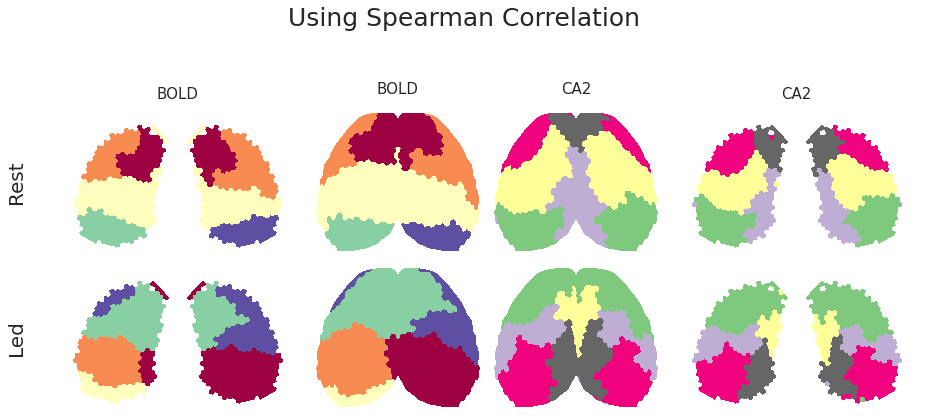

In [10]:
cmaps = ('Spectral_r', 'Accent_r')

fig, axes = create_figure(2, 4, (13, 5.5), gridspec_kw={'width_ratios': [1.5, 1, 1, 1.5]})

tr = base.trim2d(bold_rest['proj_spear'])
x2plt = tr['proj-flat'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
axes[0, 0].imshow(x2plt, cmap=cmaps[0])
x2plt = tr['proj-top'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
axes[0, 1].imshow(x2plt, cmap=cmaps[0])
axes[0, 0].set_ylabel(f"Rest\n", fontsize=20)
axes[0, 0].set_title(f"BOLD", fontsize=15, y=1.04)
axes[0, 1].set_title(f"BOLD", fontsize=15, y=1.09)

tr = base.trim2d(ca2_rest['proj_spear'])
x2plt = tr['proj-top'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
axes[0, 2].imshow(x2plt, cmap=cmaps[1])
x2plt = tr['proj-flat'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
axes[0, 3].imshow(x2plt, cmap=cmaps[1])
axes[0, 3].set_title(f"CA2", fontsize=15, y=1.04)
axes[0, 2].set_title(f"CA2", fontsize=15, y=1.09)


tr = base.trim2d(bold_led['proj_spear'])
x2plt = tr['proj-flat'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
axes[1, 0].imshow(x2plt, cmap=cmaps[0])
x2plt = tr['proj-top'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
axes[1, 1].imshow(x2plt, cmap=cmaps[0])
axes[1, 0].set_ylabel(f"Led\n", fontsize=20)

tr = base.trim2d(ca2_led['proj_spear'])
x2plt = tr['proj-top'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
axes[1, 2].imshow(x2plt, cmap=cmaps[1])
x2plt = tr['proj-flat'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
axes[1, 3].imshow(x2plt, cmap=cmaps[1])

sup = fig.suptitle("Using Spearman Correlation", fontsize=25, y=1.08)
remove_ticks(axes)
figs.append(fig)
sups.append(sup)
plt.show()

In [11]:
save_fig(figs, sups, pjoin(tmp_dir, 'hierarchical_group_nogsr.pdf'), multi=True)

In [12]:
from nancorrmp.nancorrmp import NaNCorrMp
from analysis.hierarchical import get_clust_graph, sp_hier

def fit_hier_group(mode, task, nogsr, perc=10):
    mice = Mice((512, 4))
    mice.setup_func_data(task, nogsr=nogsr)
    proc, *_ = mice.get_data_containers(mode)

    adj_pears = []
    adj_spear = []
    for key, func in tqdm(proc.items()):
        if mice.looper[key][-1] < 0:
            continue

        base = Base(mice, key=key, mode=mode, task=task)

        a, p = NaNCorrMp.calculate_with_p_value(base.data)
        a[p > 0.05] = np.nan
        adj_pears.append(np.expand_dims(a, 0))

        a, p = sp_stats.spearmanr(base.data, axis=1)
        a[p > 0.05] = np.nan
        adj_spear.append(np.expand_dims(a, 0))

    adj_pears = np.concatenate(adj_pears)
    adj_pears = bn.nanmean(adj_pears, 0)
    adj_spear = np.concatenate(adj_spear)
    adj_spear = bn.nanmean(adj_spear, 0)

    for i in range(len(adj_pears)):
        nans = np.isnan(adj_pears[i])
        adj_pears[i][nans] = bn.nanmean(adj_pears[i])

    for i in range(len(adj_spear)):
        nans = np.isnan(adj_spear[i])
        adj_spear[i][nans] = bn.nanmean(adj_spear[i])
        
    al = adj_pears[np.tril_indices_from(adj_pears)]
    thres = np.percentile(al, 100 - perc)
    adj_pears[adj_pears <= thres] = 0.0
    
    al = adj_spear[np.tril_indices_from(adj_spear)]
    thres = np.percentile(al, 100 - perc)
    adj_spear[adj_spear <= thres] = 0.0

    a_sym = (adj_pears + adj_pears.T) / 2
    d_pears = 1 - a_sym

    a_sym = (adj_spear + adj_spear.T) / 2
    d_spear = 1 - a_sym
    
    z_pears = sp_hier.linkage(
        sp_dist.squareform(d_pears),
        method='ward',
        metric='correlation',
        optimal_ordering=True,
    )
    result = get_clust_graph(
        linkage_mat=z_pears,
        labels=base.l2n,
        num_clusters=5,
    )
    comm_vec = np.zeros(len(base.n2l))
    for c_idx, clist in result['cluster_assigns'].items():
        for lbl in clist:
            comm_vec[base.l2n[lbl]] = c_idx
    proj_pears = base.project_vec(comm_vec)

    z_spear = sp_hier.linkage(
        sp_dist.squareform(d_spear),
        method='ward',
        metric='correlation',
        optimal_ordering=True,
    )
    result = get_clust_graph(
        linkage_mat=z_spear,
        labels=base.l2n,
        num_clusters=5,
    )
    comm_vec = np.zeros(len(base.n2l))
    for c_idx, clist in result['cluster_assigns'].items():
        for lbl in clist:
            comm_vec[base.l2n[lbl]] = c_idx
    proj_spear = base.project_vec(comm_vec)
    
    output = {
        'd_pears': d_pears,
        'd_spear': d_spear,
        'proj_pears': proj_pears,
        'proj_spear': proj_spear,
    }
    return output

In [13]:
ca2_led = fit_hier_group('ca2', 'led', True)
ca2_rest = fit_hier_group('ca2', 'rest', True)

bold_led = fit_hier_group('bold-lite', 'led', True)
bold_rest = fit_hier_group('bold-lite', 'rest', True)

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

In [14]:
figs, sups = [], []

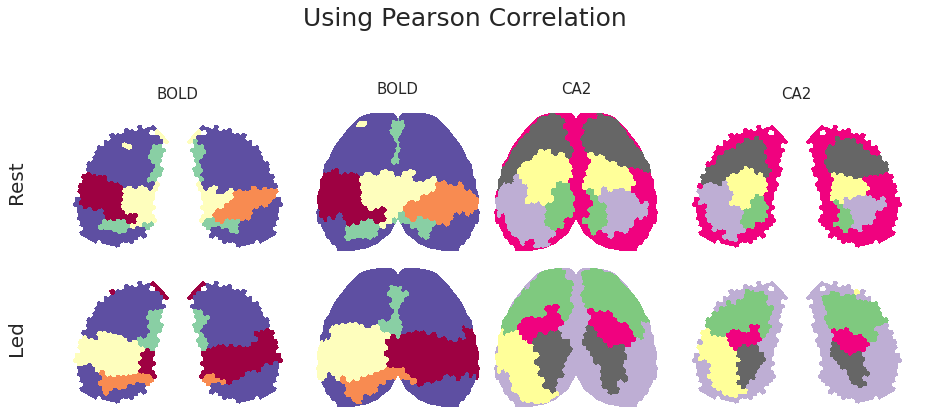

In [15]:
cmaps = ('Spectral_r', 'Accent_r')

fig, axes = create_figure(2, 4, (13, 5.5), gridspec_kw={'width_ratios': [1.5, 1, 1, 1.5]})

tr = base.trim2d(bold_rest['proj_pears'])
x2plt = tr['proj-flat'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
axes[0, 0].imshow(x2plt, cmap=cmaps[0])
x2plt = tr['proj-top'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
axes[0, 1].imshow(x2plt, cmap=cmaps[0])
axes[0, 0].set_ylabel(f"Rest\n", fontsize=20)
axes[0, 0].set_title(f"BOLD", fontsize=15, y=1.04)
axes[0, 1].set_title(f"BOLD", fontsize=15, y=1.09)

tr = base.trim2d(ca2_rest['proj_pears'])
x2plt = tr['proj-top'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
axes[0, 2].imshow(x2plt, cmap=cmaps[1])
x2plt = tr['proj-flat'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
axes[0, 3].imshow(x2plt, cmap=cmaps[1])
axes[0, 3].set_title(f"CA2", fontsize=15, y=1.04)
axes[0, 2].set_title(f"CA2", fontsize=15, y=1.09)


tr = base.trim2d(bold_led['proj_pears'])
x2plt = tr['proj-flat'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
axes[1, 0].imshow(x2plt, cmap=cmaps[0])
x2plt = tr['proj-top'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
axes[1, 1].imshow(x2plt, cmap=cmaps[0])
axes[1, 0].set_ylabel(f"Led\n", fontsize=20)

tr = base.trim2d(ca2_led['proj_pears'])
x2plt = tr['proj-top'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
axes[1, 2].imshow(x2plt, cmap=cmaps[1])
x2plt = tr['proj-flat'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
axes[1, 3].imshow(x2plt, cmap=cmaps[1])

sup = fig.suptitle("Using Pearson Correlation", fontsize=25, y=1.08)
remove_ticks(axes)
figs.append(fig)
sups.append(sup)
plt.show()

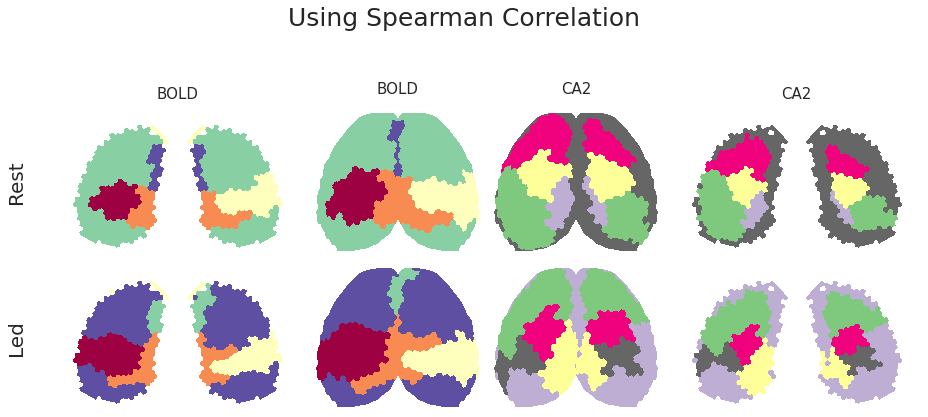

In [16]:
cmaps = ('Spectral_r', 'Accent_r')

fig, axes = create_figure(2, 4, (13, 5.5), gridspec_kw={'width_ratios': [1.5, 1, 1, 1.5]})

tr = base.trim2d(bold_rest['proj_spear'])
x2plt = tr['proj-flat'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
axes[0, 0].imshow(x2plt, cmap=cmaps[0])
x2plt = tr['proj-top'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
axes[0, 1].imshow(x2plt, cmap=cmaps[0])
axes[0, 0].set_ylabel(f"Rest\n", fontsize=20)
axes[0, 0].set_title(f"BOLD", fontsize=15, y=1.04)
axes[0, 1].set_title(f"BOLD", fontsize=15, y=1.09)

tr = base.trim2d(ca2_rest['proj_spear'])
x2plt = tr['proj-top'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
axes[0, 2].imshow(x2plt, cmap=cmaps[1])
x2plt = tr['proj-flat'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
axes[0, 3].imshow(x2plt, cmap=cmaps[1])
axes[0, 3].set_title(f"CA2", fontsize=15, y=1.04)
axes[0, 2].set_title(f"CA2", fontsize=15, y=1.09)


tr = base.trim2d(bold_led['proj_spear'])
x2plt = tr['proj-flat'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
axes[1, 0].imshow(x2plt, cmap=cmaps[0])
x2plt = tr['proj-top'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
axes[1, 1].imshow(x2plt, cmap=cmaps[0])
axes[1, 0].set_ylabel(f"Led\n", fontsize=20)

tr = base.trim2d(ca2_led['proj_spear'])
x2plt = tr['proj-top'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
axes[1, 2].imshow(x2plt, cmap=cmaps[1])
x2plt = tr['proj-flat'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
axes[1, 3].imshow(x2plt, cmap=cmaps[1])

sup = fig.suptitle("Using Spearman Correlation", fontsize=25, y=1.08)
remove_ticks(axes)
figs.append(fig)
sups.append(sup)
plt.show()

In [17]:
save_fig(figs, sups, pjoin(tmp_dir, 'hierarchical_group_nogsr_p20.pdf'), multi=True)